# One vs One

## Algoritmo

En la clasificación One vs One, para el conjunto de datos de instancias de N clases, se tienen que generar $N*(N-1)/2$ modelos clasificadores binarios. Con este enfoque de clasificación, se divide el conjunto de datos primario en un conjunto de datos para cada clase opuesta a las demás clases.

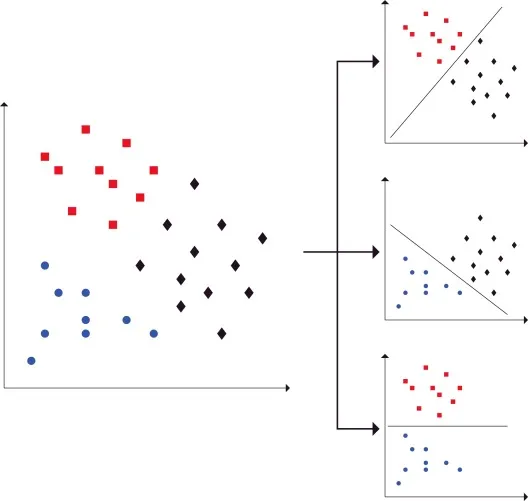

Tomando el ejemplo anterior, si se tiene un problema de clasificación con tres clases: Verde, Azul y Rojo (N=3), los clasificadores binarios quedarían de la siguiente manera:

| Clasificador | One   | One  |
| :---:        | :---  | :--- |
| 1            | Verde | Azul |
| 2            | Verde | Rojo |
| 3            | Azul  | Rojo |

Se tienen 3 clasificadores ya que $3 * (3 - 1) / 2 = 3$.

Para crear los sets de entrenamiento se puede realizar un mapeo en el que la etiqueta de una clase se convierta en 1, la etiqueta de la otra clase se convierta en 0 y las etiquetas de las demás clases se retiren del set de entrenamiento. Con este procedimiento, se puede operar conforme al algoritmo One vs One.

## Ventajas y desventajas 

### Ventajas 

- Buenos resultados 
- Más eficiente cuando aumentan las etiquetas, ya que solo toma 2 en cuenta para cada una de las combinaciones posibles 

### Desventajas

- Genera más modelos clasificadores cuando aumentan las clases ($N$ vs $N * (N - 1) / 2$)
- Conceptualmente es un poco más complicado que one vs all 
- La información requiere un paso más de filtrado, aparte del de mapeo (que igual se requiere en one vs all)

## Recomendaciones de uso

Se recomienda utilizar este algoritmo cuando el dataset tiene un número considerable de clases.

# Implementación en Python para el dataset "iris"

Se importan las librerías necesarias y se configura un logger, el cual fue utilizado para debuggear, cuando fue necesario. Por el momento, ya que no es necesario, por el momento, se encuentra desactivado.

In [21]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)
logging.disable()

Este filtro se encarga de hacer un mapeo sobre un set de etiquetas para poder cumplir con el requisito de One vs One. Si la etiqueta es de la clase 1, se convierte en 1; si la etiqueta es de la clase 2, se convierte en 0; y, finalmente, si la etiqueta no es ni de la clase 1 ni de la clase 2, se convierte en -1. Esto para poder retirar después los valores -1 del set de entrenamiento, ya que estos no son de interés.

Ejemplo:

Se tienen 3 clases: 10, 20 y 30. El array de entrada es [10, 20, 30, 10, 20] y se desea un One vs One para 10 vs 30. Este filtro convierte el array a [1, -1, 0, 1, -1].

In [22]:
def one_vs_one_filter(value: float, option_1: float, option_2: float) -> int:
    if value == option_1:
        return 1
    elif value == option_2:
        return 0
    return -1

Esta función se encarga de generar las combinaciones posibles para el One vs One, es decir, las $N * (N - 1) / 2$ combinaciones posibles.

Es decir, si se tienen 3 clases: 0, 1 y 2; esta función genera una lista de tuples de la siguiente manera: [(0, 1), (0, 2), (1, 2)].

In [23]:
def create_combinations(targets: dict[int, str]) -> list[tuple[int, int]]:
    combinations: list[tuple[int, int]] = []
    keys = targets.keys()
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            combinations.append((i, j))
    return combinations

Se carga el dataset de iris.

In [24]:
iris: Bunch = load_iris()  # type: ignore

Se obtienen los datos de entrada y de salida con los cuales se desean generar los modelos.

In [25]:
x_data: np.ndarray = iris.get("data")  # type: ignore
y_data: np.ndarray = iris.get("target")  # type: ignore

Se obtiene las clases del dataset, se genera un diccionario que relaciona su valor numérico con su nombre y se crean las combinaciones posibles para el número de etiquetas en el dataset.

In [26]:
target_names: list[str] = iris.get("target_names")  # type:ignore
targets: dict[int, str] = {k: v for k, v in enumerate(target_names)}
combinations = create_combinations(targets)
                                                                                 
logging.info(f"Combinations: {combinations}")

Se utiliza la función de scikit learn para la selección de valores en x y y para entrenamiento y testeo.

In [27]:
train_test_arrays: list[np.ndarray] = train_test_split(
    x_data, y_data
)  # type:ignore
x_train, x_test, y_train, y_test = train_test_arrays

Se itera sobre cada combinación posible, para entrenar los modelos de clasifcación binaria para cada uno de los pares de etiquetas del dataset.

Las variables con terminación \_mapped son las que ya tienen filtrado los valores -1 del set de entrenamiento. Esto es para que solo se entrene con los valores de 2 etiquetas (que tienen los valores 1 y 0) y las demás etiquetas se ignoren (tienen el valor de -1). Esto es por medio de la función de filtrado one\_vs\_one\_filter.

Finalmente, para cada combinación, se guarda el clasificador binario en un diccionario en el que la llave es la combinación con la que se entrenó el modelo.

In [28]:
models: dict[tuple[int, int], LogisticRegression] = {}
                                                                                 
for combination in combinations:
    class_1, class_2 = combination
                                                                                 
    logging.info(f"Training model for {targets[class_1]} vs {targets[class_2]}")
                                                                                 
    helper_array_model_1 = np.ones((len(y_train), 1)).flatten() * class_1
    helper_array_model_2 = np.ones((len(y_train), 1)).flatten() * class_2
                                                                                 
    logging.info(np.mean(helper_array_model_1, dtype=float))
    logging.info(np.mean(helper_array_model_2, dtype=float))
                                                                                 
    y_train_mapped = np.array(
        list(map(one_vs_one_filter, y_train, helper_array_model_1, helper_array_model_2))
    )
                                                                                 
    x_train_mapped = x_train[y_train_mapped != -1]
    y_train_mapped = y_train_mapped[y_train_mapped != -1]
                                                                                 
    model = LogisticRegression(C=10**10)
    model.fit(x_train_mapped, y_train_mapped)
                                                                                 
    logging.info(f"Classses are ordered like this: {model.classes_}")
                                                                                 
    models[combination] = model
                                                                                 
logging.info(f"Models trained: {models}")

Ya con los clasificadores binarios, se itera sobre cada uno de los valores de prueba que se definieron con anterioridad. Dentro de esa iteración, se itera sobre cada uno de los clasificadores binarios entrenados, para poder obtener la probabilidad de que le entrada sea para una salida de alguna etiqueta. Estas probabilidad son guardadas en un diccionario de probabilidades en el cual la llave es la etiqueta de la clase y el valor son una lista de numeros flotantes, es decir, las probabilidades calculadas por los modelos para cada una de las clases.

Luego de iterar sobre cada uno de los modelos, se obtiene la probabilidad con mayor valor del diccionario de probabilidades, para poder obtener la predicción final para la entrada utilizada.

Finalmente, se lleva una lista de booleanos para poder saber, al final de la iteración de los valores de prueba, el porcentaje de precciones que fueron realizadas correctamente.

In [29]:
success: list[bool] = []
for x, y in zip(x_test, y_test):
    probabilities: dict[int, list[float]] = {}
    for combination, model in models.items():
        class_1, class_2 = combination
                                                                                 
        logging.info(f"Class 1: {class_1}")
        logging.info(f"Class 2: {class_2}")
                                                                                 
        results: np.ndarray = model.predict_proba(x.reshape(1, -1))
        prob_class_2 = results[0, 0]
        prob_class_1 = results[0, 1]
                                                                                 
        if class_1 not in probabilities:
            probabilities[class_1] = []
        if class_2 not in probabilities:
            probabilities[class_2] = []
                                                                                 
        probabilities[class_1] = probabilities[class_1] + [prob_class_1]
        probabilities[class_2] = probabilities[class_2] + [prob_class_2]
                                                                                 
    logging.info(probabilities)
                                                                                 
    predicted = max(probabilities, key=lambda x: np.mean(probabilities[x], dtype=float))
    expected = y
                                                                                 
    if predicted == expected:
        success.append(True)
    else:
        success.append(False)
                                                                                 
    logging.info(f"Predicted: {predicted}. Expected: {expected}")

Porcentaje de precciones correctas para el algoritmo one vs one.

In [30]:
print(f"Success rate: {success.count(True) / len(success)}")

Success rate: 1.0
